Introduction
This assignment aims to give you an idea of applying EDA in a real business scenario. In this assignment, apart from applying the techniques that you have learnt in the EDA module, you will also develop a basic understanding of risk analytics in banking and financial services and understand how data is used to minimise the risk of losing money while lending to customers.

 

Business Understanding
The loan providing companies find it hard to give loans to the people due to their insufficient or non-existent credit history. Because of that, some consumers use it to their advantage by becoming a defaulter. Suppose you work for a consumer finance company which specialises in lending various types of loans to urban customers. You have to use EDA to analyse the patterns present in the data. This will ensure that the applicants capable of repaying the loan are not rejected.

 

When the company receives a loan application, the company has to decide for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:

If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company

If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company.

 

The data given below contains the information about the loan application at the time of applying for the loan. It contains two types of scenarios:

The client with payment difficulties: he/she had late payment more than X days on at least one of the first Y instalments of the loan in our sample,

All other cases: All other cases when the payment is paid on time.

 

When a client applies for a loan, there are four types of decisions that could be taken by the client/company):

Approved: The Company has approved loan Application

Cancelled: The client cancelled the application sometime during approval. Either the client changed her/his mind about the loan or in some cases due to a higher risk of the client, he received worse pricing which he did not want.

Refused: The company had rejected the loan (because the client does not meet their requirements etc.).

Unused offer:  Loan has been cancelled by the client but at different stages of the process.

In this case study, you will use EDA to understand how consumer attributes and loan attributes influence the tendency to default.

 

Business Objectives
This case study aims to identify patterns which indicate if a client has difficulty paying their instalments which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc. This will ensure that the consumers capable of repaying the loan are not rejected. Identification of such applicants using EDA is the aim of this case study.

 

In other words, the company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment.

To develop your understanding of the domain, you are advised to independently research a little about risk analytics - understanding the types of variables and their significance should be enough.

In [330]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [331]:
appdata=pd.read_csv("application_data.csv")
#appdata.head()

## Handle Missing Values

In [332]:
nullcolumns=pd.DataFrame(100*appdata.isnull().sum()/len(appdata)).reset_index()
#nullcolumns=nullcolumns.reset_index()
nullcolumns.columns=["col_name","percentage"]
nullcolumns=nullcolumns.sort_values(by="percentage",ascending=False)
nullcolumns.to_csv("nullappdata.csv",index=False)

#### Check Distribution of Target Column 

In [333]:
appdata.TARGET.value_counts(normalize=True)*100

TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64

In [334]:
appdata["NAME_CONTRACT_TYPE"].value_counts(normalize=True)*100

NAME_CONTRACT_TYPE
Cash loans         90.478715
Revolving loans     9.521285
Name: proportion, dtype: float64

In [335]:
appdata["FLAG_OWN_CAR"].value_counts(normalize=True)

FLAG_OWN_CAR
N    0.659892
Y    0.340108
Name: proportion, dtype: float64

In [336]:
appdata["OWN_CAR_AGE"]=appdata["OWN_CAR_AGE"].fillna(0)
appdata["OCCUPATION_TYPE"]=appdata["OCCUPATION_TYPE"].fillna("NOT DECLARED") #as there are 31% records
 


### Check and Remove Outliers - AMT_INCOME_TOTAL

In [337]:
appdata["AMT_INCOME_TOTAL"].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

##### Create AMT_INCOME_TOTAL IN Lakhs

In [338]:
appdata["AMT_INCOME_TOTAL_LKHS"]=appdata["AMT_INCOME_TOTAL"]*1.0/100000.0
appdata["AMT_INCOME_TOTAL_LKHS"].describe()

count    307511.000000
mean          1.687979
std           2.371231
min           0.256500
25%           1.125000
50%           1.471500
75%           2.025000
max        1170.000000
Name: AMT_INCOME_TOTAL_LKHS, dtype: float64

<Axes: ylabel='AMT_INCOME_TOTAL_LKHS'>

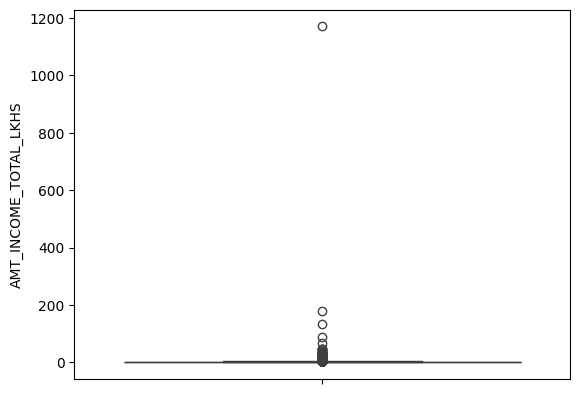

In [339]:
sns.boxplot(appdata["AMT_INCOME_TOTAL_LKHS"],orient="v")

In [340]:
Q1_AMT_INCOME_TOTAL_LKHS=appdata["AMT_INCOME_TOTAL_LKHS"].quantile(0.25)
Q3_AMT_INCOME_TOTAL_LKHS=appdata["AMT_INCOME_TOTAL_LKHS"].quantile(0.75)
IQR_AMT_INCOME_TOTAL_LKHS=Q3_AMT_INCOME_TOTAL_LKHS-Q1_AMT_INCOME_TOTAL_LKHS
IQRmin_AMT_INCOME_TOTAL_LKHS=Q1_AMT_INCOME_TOTAL_LKHS-(1.5*IQR_AMT_INCOME_TOTAL_LKHS)
IQRmax_AMT_INCOME_TOTAL_LKHS=Q3_AMT_INCOME_TOTAL_LKHS+(1.5*IQR_AMT_INCOME_TOTAL_LKHS)
appdata["OUTL_AMT_INCOME_TOTAL_LKHS"]=appdata["AMT_INCOME_TOTAL_LKHS"].apply(lambda x: 1 if x<IQRmin_AMT_INCOME_TOTAL_LKHS or x>IQRmax_AMT_INCOME_TOTAL_LKHS else 0)
appdata["OUTL_AMT_INCOME_TOTAL_LKHS"].value_counts(normalize=True)*100



OUTL_AMT_INCOME_TOTAL_LKHS
0    95.435936
1     4.564064
Name: proportion, dtype: float64

##### Remove the AMT_INCOME_TOTAL Outlier Records

In [341]:
appdata=appdata[appdata["OUTL_AMT_INCOME_TOTAL_LKHS"]==0]
len(appdata[appdata["OUTL_AMT_INCOME_TOTAL_LKHS"]==1])

0

### Check and Remove Outlier - Count of Children & Count of Family Members

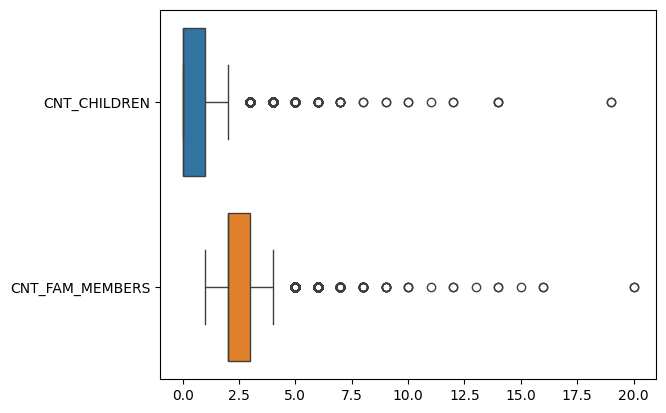

In [342]:
sns.boxplot([appdata.CNT_CHILDREN,appdata.CNT_FAM_MEMBERS],orient='h')
plt.show()

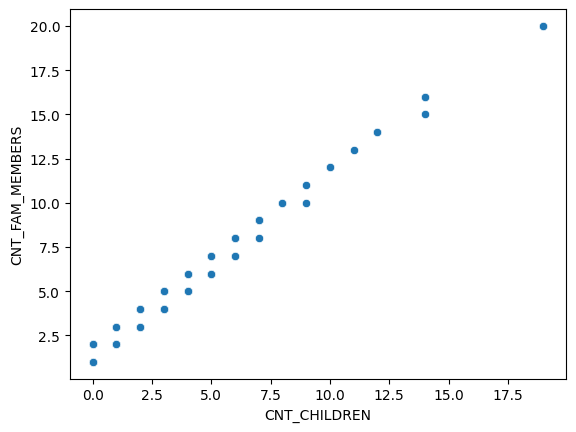

In [343]:
sns.scatterplot(x=appdata.CNT_CHILDREN,y=appdata.CNT_FAM_MEMBERS)
plt.show()

<Axes: >

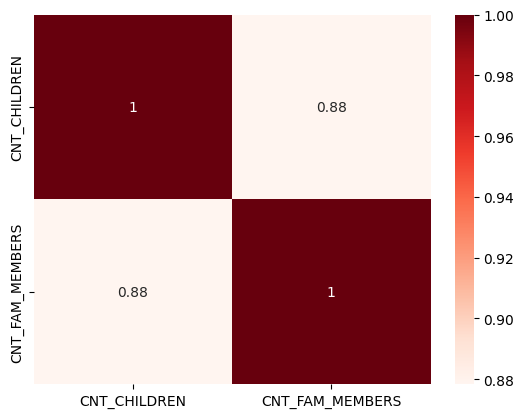

In [344]:
sns.heatmap(appdata[["CNT_CHILDREN","CNT_FAM_MEMBERS"]].corr(),annot=True,cmap="Reds")

#### Remove Outlier - CNT_CHILDREN

In [345]:
Q1_CNT_CHILDREN= appdata.CNT_CHILDREN.quantile(0.25)
Q3_CNT_CHILDREN=appdata.CNT_CHILDREN.quantile(0.75)
IQR_CNT_CHILDREN=Q3_CNT_CHILDREN-Q1_CNT_CHILDREN
IQRmin_CNT_CHILDREN=Q1_CNT_CHILDREN-(1.5*IQR_CNT_CHILDREN)
IQRmax_CNT_CHILDREN=Q3_CNT_CHILDREN+(1.5*IQR_CNT_CHILDREN)
appdata["OUTL_CNT_CHILDREN"]=appdata["CNT_CHILDREN"].apply(lambda x: 1 if x<IQRmin_CNT_CHILDREN or x>IQRmax_CNT_CHILDREN else 0)
appdata["OUTL_CNT_CHILDREN"].value_counts(normalize=True)*100


OUTL_CNT_CHILDREN
0    98.635323
1     1.364677
Name: proportion, dtype: float64

#### Remove Outlier - CNT_CHILDREN

In [346]:
appdata=appdata[appdata["OUTL_CNT_CHILDREN"]==0]
len(appdata[appdata["OUTL_CNT_CHILDREN"]==1])

0

### Remove Outliers - CNT_FAM_MEMBERS

<Axes: >

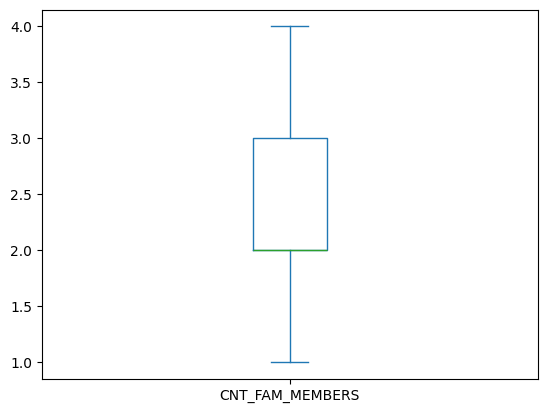

In [347]:
appdata.CNT_FAM_MEMBERS.plot.box()


#### Outlier seems to be removed as CNT_FAM_MEMBERS is closely correlated with CNT_CHILD_COUNT

### Data Transformations

##### FLAG_OWN_CAR , FLAG_OWN_REALTY

In [348]:
print(appdata.FLAG_OWN_CAR.value_counts(normalize=True)*100)
print(appdata.FLAG_OWN_REALTY.value_counts(normalize=True)*100)


FLAG_OWN_CAR
N    67.256133
Y    32.743867
Name: proportion, dtype: float64
FLAG_OWN_REALTY
Y    69.316443
N    30.683557
Name: proportion, dtype: float64


In [349]:
appdata["FLAG_OWN_CAR_VAL"]=appdata["FLAG_OWN_CAR"].apply(lambda x: 1 if x=='Y' else 0)
appdata["FLAG_OWN_REALTY_VAL"]=appdata["FLAG_OWN_REALTY"].apply(lambda x: 1 if x=='Y' else 0)


##### Calculate Age column from DAYS_BIRTH

In [350]:
appdata.DAYS_BIRTH.value_counts(normalize=True)*100

DAYS_BIRTH
-13749    0.014509
-10020    0.014164
-18248    0.014164
-15771    0.013818
-14395    0.013473
            ...   
-24894    0.000345
-25127    0.000345
-16436    0.000345
-24860    0.000345
-25061    0.000345
Name: proportion, Length: 17459, dtype: float64

In [351]:
appdata["YRS_BIRTH"]=np.abs(appdata["DAYS_BIRTH"])*1.0/365.0
appdata["YRS_BIRTH"].value_counts(normalize=True)*100

YRS_BIRTH
37.668493    0.014509
27.452055    0.014164
49.994521    0.014164
43.208219    0.013818
39.438356    0.013473
               ...   
68.202740    0.000345
68.841096    0.000345
45.030137    0.000345
68.109589    0.000345
68.660274    0.000345
Name: proportion, Length: 17459, dtype: float64

#### Age Group Creation

In [352]:
appdata.loc[appdata["YRS_BIRTH"]<20,'AGE_GROUP']='Below 20'
appdata.loc[appdata["YRS_BIRTH"].between(20,30),'AGE_GROUP']='20 to 30'
appdata.loc[appdata["YRS_BIRTH"].between(30,40),'AGE_GROUP']='30 to 40'
appdata.loc[appdata["YRS_BIRTH"].between(40,50),'AGE_GROUP']='40 to 50'
appdata.loc[appdata["YRS_BIRTH"].between(50,60),'AGE_GROUP']='50 to 60'
appdata.loc[appdata["YRS_BIRTH"]>60,'AGE_GROUP']='Above 60'
appdata["AGE_GROUP"].value_counts(normalize=True)*100







AGE_GROUP
30 to 40    25.988441
40 to 50    24.540282
50 to 60    22.452681
20 to 30    14.994939
Above 60    12.023657
Name: proportion, dtype: float64

### Experience Group Creation

In [353]:
appdata["DAYS_EMPLOYED"].value_counts(normalize=True)*100.0

DAYS_EMPLOYED
 365243    18.713446
-200        0.051819
-230        0.049400
-224        0.049055
-199        0.049055
             ...    
-8324       0.000345
-14145      0.000345
-9013       0.000345
-13650      0.000345
-8694       0.000345
Name: proportion, Length: 12481, dtype: float64

In [354]:
appdata["YRS_EMPLOYED"]=np.abs(appdata["DAYS_EMPLOYED"]*1.0/365.0)
appdata["YRS_EMPLOYED"].value_counts(normalize=True)*100

YRS_EMPLOYED
1000.665753    18.713446
0.547945        0.051819
0.630137        0.049400
0.613699        0.049055
0.545205        0.049055
                 ...    
22.805479       0.000345
38.753425       0.000345
24.693151       0.000345
37.397260       0.000345
23.819178       0.000345
Name: proportion, Length: 12481, dtype: float64

#### Remove Outliers if any from YRS_EMPLOYED

<Axes: xlabel='YRS_EMPLOYED'>

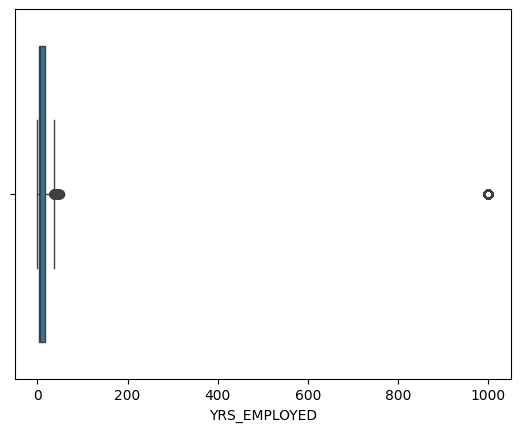

In [355]:
sns.boxplot(appdata["YRS_EMPLOYED"],orient="h")

<Axes: ylabel='Frequency'>

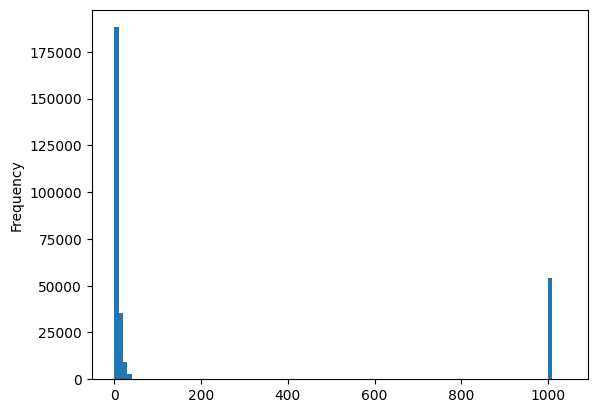

In [356]:
lbins=[]
for i in range(0,1050,10):
    lbins.append(i)
appdata.YRS_EMPLOYED.plot.hist(bins=lbins)

##### Cleanup Records with YRS_EMPLOYED >50

<Axes: >

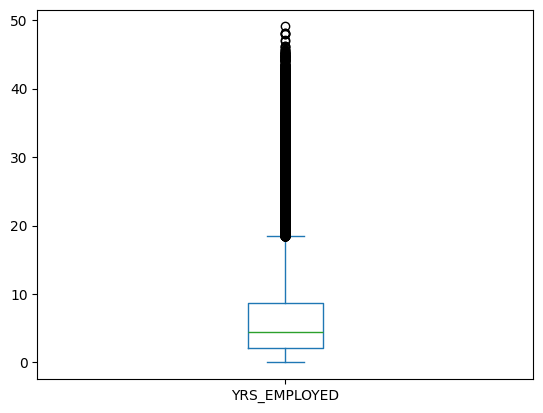

In [357]:
appdata=appdata[appdata["YRS_EMPLOYED"]<=50]
#PLot Again and check
appdata.YRS_EMPLOYED.plot.box()

In [358]:
for j in range(0,50,5):
    startval2=j
    endval2=j+5
    groupText2=str(startval2)+' to '+str(endval2)
    appdata.loc[appdata['YRS_EMPLOYED'].between(startval2,endval2),'EXP_GROUP']=str(groupText2)
appdata['EXP_GROUP'].value_counts(normalize=True)*100.0

EXP_GROUP
0 to 5      54.449407
5 to 10     25.482255
10 to 15    10.785760
15 to 20     4.220552
20 to 25     2.495527
25 to 30     1.345936
30 to 35     0.788777
35 to 40     0.336165
40 to 45     0.085423
45 to 50     0.010200
Name: proportion, dtype: float64

#### INCOME GROUP CREATION

In [359]:
appdata.AMT_INCOME_TOTAL_LKHS.value_counts(normalize=True)*100

AMT_INCOME_TOTAL_LKHS
1.350000    12.631056
1.125000    10.516317
1.575000     9.532471
1.800000     9.119383
2.250000     7.728399
              ...    
0.645840     0.000425
1.428975     0.000425
1.091700     0.000425
2.317500     0.000425
1.130625     0.000425
Name: proportion, Length: 1935, dtype: float64

In [360]:

for i in range(0,400,25):
    startval=i*1.0/100.0
    nxtVal=startval+0.25
    groupText=str(startval)+' to '+str(nxtVal)
    appdata.loc[appdata["AMT_INCOME_TOTAL_LKHS"].between(startval,nxtVal),'INCOME_GROUP']=str(groupText)
appdata.INCOME_GROUP.value_counts(normalize=True)

INCOME_GROUP
1.25 to 1.5    0.166595
1.0 to 1.25    0.145677
0.75 to 1.0    0.123544
1.5 to 1.75    0.122775
1.75 to 2.0    0.108266
2.25 to 2.5    0.104449
2.0 to 2.25    0.073298
0.5 to 0.75    0.050098
2.5 to 2.75    0.048100
3.0 to 3.25    0.025831
2.75 to 3.0    0.015708
0.25 to 0.5    0.008143
3.25 to 3.5    0.007518
Name: proportion, dtype: float64

### Data Transformation- DAYS_REGISTRATION

In [361]:
appdata["DAYS_REGISTRATION"].value_counts(normalize=True)*100

DAYS_REGISTRATION
-6.0        0.033999
-1.0        0.033574
-2.0        0.033574
-4.0        0.030599
-5.0        0.029324
              ...   
-12351.0    0.000425
-11792.0    0.000425
-13152.0    0.000425
-13719.0    0.000425
-12372.0    0.000425
Name: proportion, Length: 14357, dtype: float64

In [362]:
appdata["YRS_REGISTRATION"]=np.abs(appdata["DAYS_REGISTRATION"])*1.0/365.0

##### Investigate for Outliers

<Axes: ylabel='Frequency'>

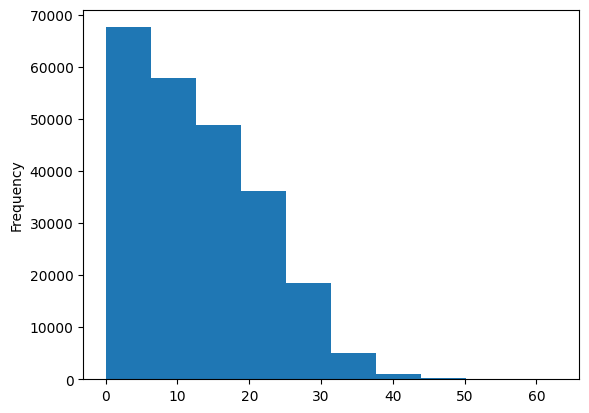

In [363]:
appdata["YRS_REGISTRATION"].plot.hist()

<Axes: >

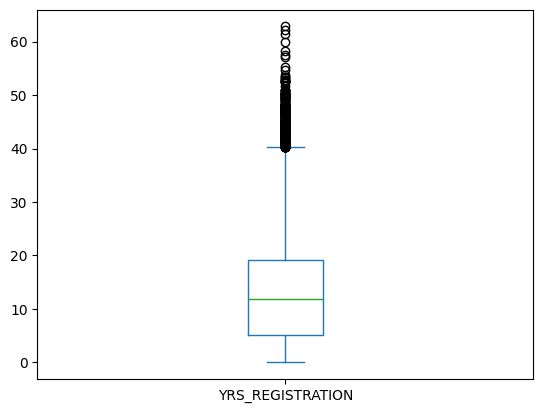

In [364]:
appdata["YRS_REGISTRATION"].plot.box()

### Data Transformation- DAYS_ID_PUBLISH

In [365]:
appdata.DAYS_ID_PUBLISH.value_counts(normalize=True)*100

DAYS_ID_PUBLISH
-4166    0.045049
-4081    0.044199
-4417    0.044199
-4046    0.043349
-4214    0.043349
           ...   
-5905    0.000425
-6062    0.000425
-7197    0.000425
-5795    0.000425
-6211    0.000425
Name: proportion, Length: 6125, dtype: float64

In [366]:
appdata["YRS_ID_PUBLISH"]=np.abs(appdata["DAYS_ID_PUBLISH"])*1.0/365.0
appdata["YRS_ID_PUBLISH"].value_counts(normalize=True)*100.0


YRS_ID_PUBLISH
11.413699    0.045049
11.180822    0.044199
12.101370    0.044199
11.084932    0.043349
11.545205    0.043349
               ...   
16.178082    0.000425
16.608219    0.000425
19.717808    0.000425
15.876712    0.000425
17.016438    0.000425
Name: proportion, Length: 6125, dtype: float64

###### CHeck for Outliers

<Axes: >

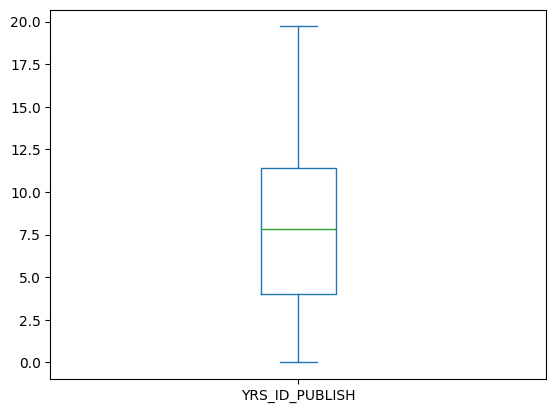

In [367]:
appdata["YRS_ID_PUBLISH"].plot.box()

<Axes: ylabel='Frequency'>

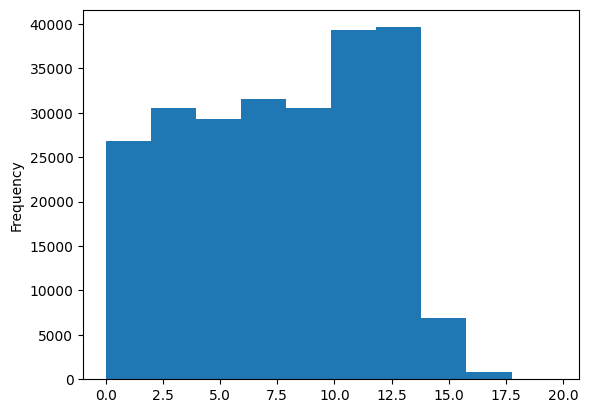

In [368]:
appdata["YRS_ID_PUBLISH"].plot.hist()

#### Check OWN_CAR_AGE column and cleanup Outliers if any

In [369]:
appdata.OWN_CAR_AGE.value_counts(normalize=True)*100

OWN_CAR_AGE
0.0     64.581961
7.0      2.602624
6.0      2.175086
3.0      2.094764
8.0      2.085839
2.0      1.924344
4.0      1.813847
9.0      1.762848
1.0      1.740324
10.0     1.675301
13.0     1.640027
14.0     1.607728
12.0     1.510831
11.0     1.460257
15.0     1.267313
5.0      1.211215
16.0     1.198465
17.0     1.024220
64.0     0.907773
18.0     0.851250
19.0     0.650231
20.0     0.538459
21.0     0.512110
22.0     0.449637
24.0     0.405438
23.0     0.380364
65.0     0.333615
25.0     0.295791
26.0     0.207819
28.0     0.182745
27.0     0.163620
29.0     0.132171
30.0     0.107097
31.0     0.087972
32.0     0.067573
34.0     0.054398
35.0     0.049724
33.0     0.044199
36.0     0.039949
38.0     0.027624
40.0     0.025074
39.0     0.025074
37.0     0.024649
41.0     0.019974
42.0     0.013175
43.0     0.005950
44.0     0.005950
54.0     0.003400
45.0     0.002975
46.0     0.001700
55.0     0.000850
49.0     0.000850
51.0     0.000850
91.0     0.000850
57.0     0.00042

<Axes: ylabel='Frequency'>

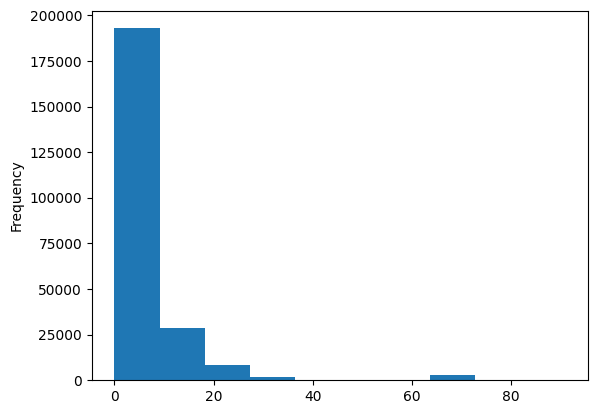

In [370]:
appdata.OWN_CAR_AGE.plot.hist()

<Axes: xlabel='OWN_CAR_AGE'>

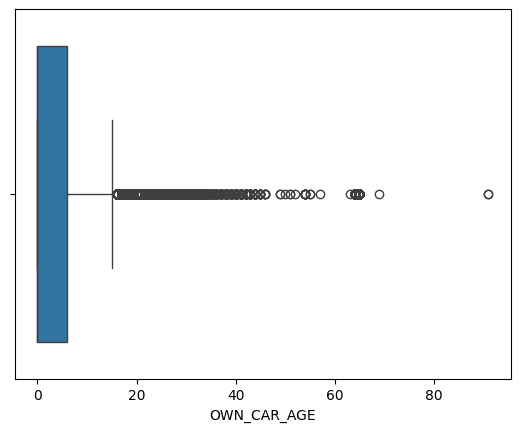

In [371]:
sns.boxplot(appdata.OWN_CAR_AGE,orient="h") 


##### Clear OWN_CAR_AGE greater than 60

In [372]:
(len(appdata[appdata["OWN_CAR_AGE"]>=60])/len(appdata[appdata["OWN_CAR_AGE"]<60]))*100.0

1.258735841911385

In [373]:
appdata=appdata[appdata["OWN_CAR_AGE"]<60]

#### Data Transformation DAYS_LAST_PHONE_CHANGE

In [374]:
appdata["YRS_LAST_PHONE_CHANGE"]=np.abs(appdata["DAYS_LAST_PHONE_CHANGE"])*1.0/365.0
appdata["YRS_LAST_PHONE_CHANGE"].value_counts(normalize=True)*100


YRS_LAST_PHONE_CHANGE
0.000000     11.598063
0.002740      0.947176
0.005479      0.696719
0.008219      0.579666
0.010959      0.455299
               ...    
10.572603     0.000430
10.257534     0.000430
9.745205      0.000430
9.635616      0.000430
9.693151      0.000430
Name: proportion, Length: 3705, dtype: float64

<Axes: >

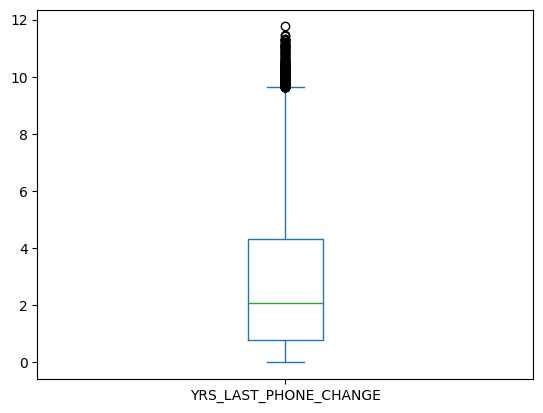

In [375]:
appdata["YRS_LAST_PHONE_CHANGE"].plot.box()

<Axes: ylabel='Frequency'>

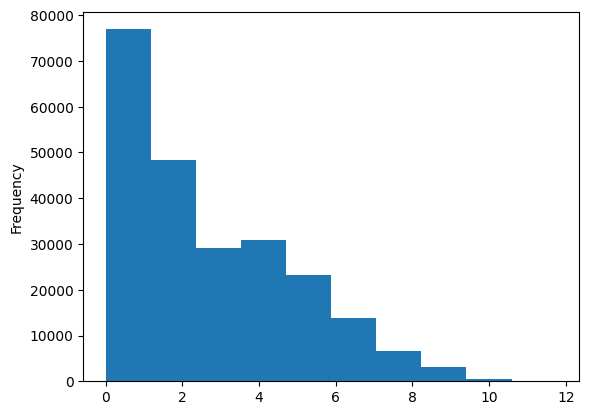

In [376]:
appdata["YRS_LAST_PHONE_CHANGE"].plot.hist()

In [377]:
appdata_flag_cols=list(appdata.columns)
appdata_flag_cols =[y for y in list(appdata.columns) if  "FLAG" in y]
appdata_flag_cols

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_OWN_CAR_VAL',
 'FLAG_OWN_REALTY_VAL']

#### Segregate Data by Type of Loans with subset of columns

In [402]:
subset_columns=[
    'SK_ID_CURR'
    ,'NAME_CONTRACT_TYPE'
    ,'CODE_GENDER'
    ,'CNT_CHILDREN'
    ,'CNT_FAM_MEMBERS'
    ,'OCCUPATION_TYPE'
    ,'YRS_EMPLOYED'
    ,'EXP_GROUP'
    ,'AMT_INCOME_TOTAL_LKHS'
    ,'INCOME_GROUP'
    ,'YRS_BIRTH'
    ,'AGE_GROUP'
    ,'NAME_EDUCATION_TYPE'
    ,'NAME_FAMILY_STATUS'
    ,'NAME_HOUSING_TYPE'
    ,'DAYS_REGISTRATION'
    ,'YRS_REGISTRATION'
    ,'YRS_LAST_PHONE_CHANGE'
    ,'OWN_CAR_AGE'
    ,'YRS_ID_PUBLISH'
    ,'FLAG_OWN_CAR_VAL'
    ,'FLAG_OWN_REALTY_VAL'
    ,'FLAG_MOBIL'
    ,'FLAG_EMP_PHONE'
,'FLAG_WORK_PHONE'
,'FLAG_CONT_MOBILE'
,'FLAG_PHONE'
,'FLAG_EMAIL','TARGET']

In [403]:
appdata.NAME_CONTRACT_TYPE.value_counts(normalize=True)*100.0

NAME_CONTRACT_TYPE
Cash loans         89.905154
Revolving loans    10.094846
Name: proportion, dtype: float64

#### Revolving Loans_Target_0.csv , Revolving Loans_Target_1.csv


In [411]:
appdata_revolving_loans_T0=appdata[(appdata['NAME_CONTRACT_TYPE']=='Revolving loans')&(appdata['TARGET']==0)][subset_columns]
appdata_revolving_loans_T0.to_csv('Revolving_loans_T0.csv',index=False)

appdata_revolving_loans_T1=appdata[(appdata['NAME_CONTRACT_TYPE']=='Revolving loans')&(appdata['TARGET']==1)][subset_columns]
appdata_revolving_loans_T1.to_csv('Revolving_loans_T1.csv',index=False)


##### Aggregate Data - Revolving Loans(agg_revolving_loans.csv)

In [405]:
# groupby_cols=["CODE_GENDER","NAME_CONTRACT_TYPE","OCCUPATION_TYPE","EXP_GROUP","INCOME_GROUP","AGE_GROUP","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE"]
# agg_cols=['CNT_CHILDREN','CNT_FAM_MEMBERS','YRS_EMPLOYED','YRS_BIRTH','YRS_REGISTRATION','YRS_LAST_PHONE_CHANGE','YRS_ID_PUBLISH','FLAG_MOBIL'
# ,'FLAG_OWN_CAR_VAL'
#     ,'FLAG_OWN_REALTY_VAL'
#     ,'FLAG_EMP_PHONE'
# ,'FLAG_WORK_PHONE'
# ,'FLAG_CONT_MOBILE'
# ,'FLAG_PHONE'
# ,'FLAG_EMAIL','TARGET']
# agg_appdata_revolving_loans=pd.DataFrame(appdata_revolving_loans.groupby(groupby_cols)[agg_cols].sum().reset_index())
# agg_appdata_revolving_loans.to_csv('agg_revolving_loans.csv',index=False)


In [ ]:
rev_cor_cols=['CNT_CHILDREN','CNT_FAM_MEMBERS','YRS_EMPLOYED','YRS_BIRTH','YRS_REGISTRATION','YRS_LAST_PHONE_CHANGE','YRS_ID_PUBLISH','FLAG_OWN_CAR_VAL'
    ,'FLAG_OWN_REALTY_VAL']

<Axes: >

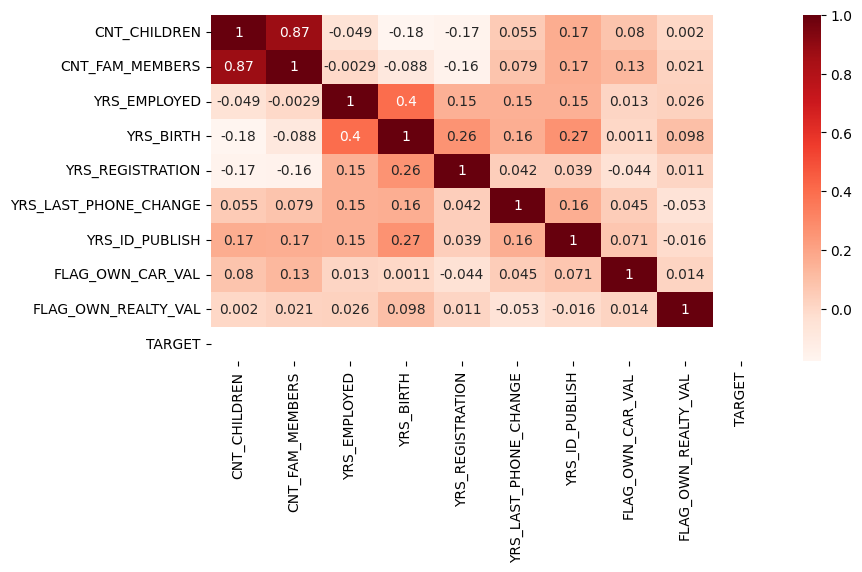

In [412]:
plt.figure(figsize=(9, 4.5))
sns.heatmap(appdata_revolving_loans_T0[rev_cor_cols].corr(),annot=True,cmap="Reds",)

<Axes: >

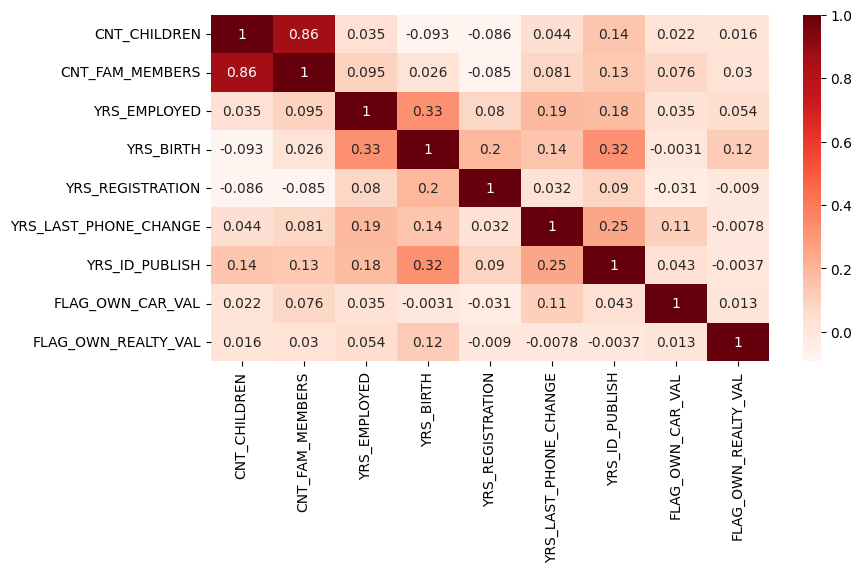

In [414]:
plt.figure(figsize=(9, 4.5))
sns.heatmap(appdata_revolving_loans_T1[rev_cor_cols].corr(),annot=True,cmap="Reds",)

In [410]:
df2=pd.DataFrame(appdata_revolving_loans.groupby(["CODE_GENDER","OCCUPATION_TYPE","NAME_FAMILY_STATUS","NAME_EDUCATION_TYPE","NAME_HOUSING_TYPE"])["TARGET"].sum().reset_index()).sort_values(by=["CODE_GENDER","OCCUPATION_TYPE","NAME_FAMILY_STATUS","NAME_EDUCATION_TYPE","NAME_HOUSING_TYPE","TARGET"],ascending=False)
df2.to_csv("df2.csv",index=False)

#### Cashloans.csv

In [447]:
appdata_cash_T0=appdata[(appdata['NAME_CONTRACT_TYPE']=='Cash loans')&(appdata['TARGET']==0)][subset_columns]
appdata_cash_T0.to_csv('Cash_loans_T0.csv',index=False)

appdata_cash_T1=appdata[(appdata['NAME_CONTRACT_TYPE']=='Cash loans')&(appdata['TARGET']==1)][subset_columns]
appdata_cash_T1.to_csv('Cash_loans_T1.csv',index=False)

## Analyse Previous Application

In [431]:
appprevdata=pd.read_csv("previous_application.csv")


In [417]:
appprevdata.CHANNEL_TYPE.value_counts(normalize=True)*100.0

CHANNEL_TYPE
Credit and cash offices       43.106332
Country-wide                  29.618360
Stone                         12.697954
Regional / Local               6.497850
Contact center                 4.268734
AP+ (Cash loan)                3.415490
Channel of corporate sales     0.368216
Car dealer                     0.027062
Name: proportion, dtype: float64

In [418]:
appprevdata.NAME_GOODS_CATEGORY.value_counts(normalize=True)*100.0

NAME_GOODS_CATEGORY
XNA                         56.927376
Mobile                      13.453845
Consumer Electronics         7.279067
Computers                    6.332662
Audio/Video                  5.953788
Furniture                    3.212522
Photo / Cinema Equipment     1.498072
Construction Materials       1.496515
Clothing and Accessories     1.410238
Auto Accessories             0.441919
Jewelry                      0.376598
Homewares                    0.300740
Medical Supplies             0.230090
Vehicles                     0.201771
Sport and Leisure            0.178480
Gardening                    0.159740
Other                        0.152915
Office Appliances            0.139683
Tourism                      0.099329
Medicine                     0.092802
Direct Sales                 0.026703
Fitness                      0.012513
Additional Service           0.007664
Education                    0.006406
Weapon                       0.004610
Insurance                    0

In [419]:
appprevdata.NAME_CLIENT_TYPE.value_counts(normalize=True)*100.0

NAME_CLIENT_TYPE
Repeater     73.718757
New          18.043376
Refreshed     8.121654
XNA           0.116213
Name: proportion, dtype: float64

In [420]:
appprevdata.NAME_CONTRACT_TYPE.value_counts(normalize=True)*100.0

NAME_CONTRACT_TYPE
Cash loans         44.757917
Consumer loans     43.656142
Revolving loans    11.565225
XNA                 0.020716
Name: proportion, dtype: float64

In [424]:
appprevdata.NAME_CASH_LOAN_PURPOSE.value_counts(normalize=True)*100.0


NAME_CASH_LOAN_PURPOSE
XAP                                 55.242083
XNA                                 40.588691
Repairs                              1.422872
Other                                0.934491
Urgent needs                         0.503648
Buying a used car                    0.172912
Building a house or an annex         0.161237
Everyday expenses                    0.144652
Medicine                             0.130163
Payments on other loans              0.115614
Education                            0.094180
Journey                              0.074182
Purchase of electronic equipment     0.063525
Buying a new car                     0.060591
Wedding / gift / holiday             0.057597
Buying a home                        0.051790
Car repairs                          0.047718
Furniture                            0.044845
Buying a holiday home / land         0.031912
Business development                 0.025506
Gasification / water supply          0.017962
Buying a ga

In [425]:
appprevdata.NAME_CONTRACT_STATUS.value_counts(normalize=True)*100.0


NAME_CONTRACT_STATUS
Approved        62.074740
Canceled        18.938831
Refused         17.403638
Unused offer     1.582791
Name: proportion, dtype: float64

In [426]:
appprevdata.CODE_REJECT_REASON.value_counts(normalize=True)*100.0

CODE_REJECT_REASON
XAP       81.013152
HC        10.491530
LIMIT      3.333705
SCO        2.243245
CLIENT     1.582791
SCOFR      0.767027
XNA        0.313972
VERIF      0.211650
SYSTEM     0.042929
Name: proportion, dtype: float64

In [427]:
appprevdata.NAME_YIELD_GROUP.value_counts(normalize=True)*100.0

NAME_YIELD_GROUP
XNA           30.966990
middle        23.082791
high          21.154834
low_normal    19.284655
low_action     5.510731
Name: proportion, dtype: float64

In [428]:
appprevdata.PRODUCT_COMBINATION.value_counts(normalize=True)*100.0


PRODUCT_COMBINATION
Cash                              17.126503
POS household with interest       15.786996
POS mobile with interest          13.214817
Cash X-Sell: middle                8.616430
Cash X-Sell: low                   7.799898
Card Street                        6.741970
POS industry with interest         5.918612
POS household without interest     4.964943
Card X-Sell                        4.825651
Cash Street: high                  3.571480
Cash X-Sell: high                  3.551239
Cash Street: middle                2.075493
Cash Street: low                   2.026148
POS mobile without interest        1.442150
POS other with interest            1.429993
POS industry without interest      0.754670
POS others without interest        0.153006
Name: proportion, dtype: float64

In [442]:
appprevdata.CODE_REJECT_REASON.value_counts(normalize=True)*100.0

CODE_REJECT_REASON
XAP       81.013152
HC        10.491530
LIMIT      3.333705
SCO        2.243245
CLIENT     1.582791
SCOFR      0.767027
XNA        0.313972
VERIF      0.211650
SYSTEM     0.042929
Name: proportion, dtype: float64

In [441]:
appprevdata[["NAME_CONTRACT_STATUS","NAME_CLIENT_TYPE","NAME_GOODS_CATEGORY","NAME_PORTFOLIO","NAME_YIELD_GROUP","NAME_PAYMENT_TYPE","CODE_REJECT_REASON"]].head()

,NAME_CONTRACT_STATUS,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_YIELD_GROUP,NAME_PAYMENT_TYPE,CODE_REJECT_REASON
0,Approved,Repeater,Mobile,POS,middle,Cash through the bank,XAP
1,Approved,Repeater,XNA,Cash,low_action,XNA,XAP
2,Approved,Repeater,XNA,Cash,high,Cash through the bank,XAP
3,Approved,Repeater,XNA,Cash,middle,Cash through the bank,XAP
4,Refused,Repeater,XNA,Cash,high,Cash through the bank,HC


### Merge with Previous Application 

##### Revolving Loans

In [445]:
prev_cols=["SK_ID_CURR","NAME_CONTRACT_STATUS","NAME_CLIENT_TYPE","NAME_PAYMENT_TYPE","NAME_GOODS_CATEGORY","NAME_PORTFOLIO","NAME_YIELD_GROUP","DAYS_FIRST_DRAWING"
,"DAYS_FIRST_DUE"
,"DAYS_LAST_DUE"
,"DAYS_TERMINATION","CODE_REJECT_REASON"
]

In [443]:

appdata_revolving_loans_T1_merge=pd.merge(appdata_revolving_loans_T1,appprevdata[prev_cols],left_on="SK_ID_CURR",right_on="SK_ID_CURR",how="left")



In [444]:
appdata_revolving_loans_T1_merge.to_csv("appdata_revolving_loans_T1_merge.csv",index=False)

##### Cash loans

In [448]:
appdata_cash_loans_T1_merge=pd.merge(appdata_cash_T1,appprevdata[prev_cols],left_on="SK_ID_CURR",right_on="SK_ID_CURR",how="left")

In [449]:
appdata_cash_loans_T1_merge.to_csv("appdata_cash_loans_T1_merge.csv",index=False)